In [1]:
# Essential imports for data science and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, roc_curve, precision_recall_curve,
                           f1_score, precision_score, recall_score)
from sklearn.utils.class_weight import compute_class_weight

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Configure visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Environment Setup:")
print(f"   Device: {device}")
print(f"   PyTorch Version: {torch.__version__}")
print(f"   Pandas Version: {pd.__version__}")
print(f"   NumPy Version: {np.__version__}")

if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

print("\n✅ All libraries imported successfully!")
print("📊 Ready to begin customer churn analysis...")

🚀 Environment Setup:
   Device: cpu
   PyTorch Version: 2.8.0+cpu
   Pandas Version: 2.3.3
   NumPy Version: 2.3.3

✅ All libraries imported successfully!
📊 Ready to begin customer churn analysis...


In [2]:
# Neural Network Model Implementation
print("🧠 NEURAL NETWORK MODEL DEVELOPMENT")
print("=" * 60)

import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import torch.optim as optim

🧠 NEURAL NETWORK MODEL DEVELOPMENT


In [3]:
# 1. DEFINE NEURAL NETWORK ARCHITECTURE
print("1️⃣ Defining Model Architecture...")

class ChurnPredictor(nn.Module):
    """
    Deep Neural Network for Customer Churn Prediction

    Architecture:
    - Input: All engineered features
    - Hidden layers with batch normalization and dropout
    - Output: Binary classification (churn probability)
    """

    def __init__(self, input_size, hidden_sizes=[256, 128, 64], dropout_rate=0.2):
        super(ChurnPredictor, self).__init__()

        # Build dynamic architecture
        layers = []
        prev_size = input_size

        for i, hidden_size in enumerate(hidden_sizes):
            # Linear layer
            layers.append(nn.Linear(prev_size, hidden_size))
            # Batch normalization
            layers.append(nn.BatchNorm1d(hidden_size))
            # Activation
            layers.append(nn.ReLU())
            # Dropout
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        # Output layer
        layers.append(nn.Linear(prev_size, 1))
        # layers.append(nn.Sigmoid())  # Sigmoid will be applied in the loss function (BCEWithLogitsLoss)

        self.network = nn.Sequential(*layers)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using Xavier/Glorot initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, x):
        return self.network(x)

1️⃣ Defining Model Architecture...


In [5]:
import pickle
import torch

# 1. Load preprocessing pipeline
with open('../outputs/preprocessing_pipeline.pkl', 'rb') as f:
    pipeline_objects = pickle.load(f)
    
# Extract all preprocessing objects
scaler = pipeline_objects['scaler']
label_encoders = pipeline_objects['label_encoders']
feature_columns = pipeline_objects['feature_columns']
categorical_features = pipeline_objects['categorical_features']
numerical_features = pipeline_objects['numerical_features']
binary_features = pipeline_objects['binary_features']
class_weight_dict = pipeline_objects['class_weight_dict']

# Save preprocessing objects for later use
preprocessing_objects = {
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_columns': feature_columns,
    'class_weights': class_weight_dict
}

# 2. Load PyTorch tensors
with open('../outputs/tensors/tensor_data.pkl', 'rb') as f:
    tensor_objects = pickle.load(f)
    
# Extract all tensors
X_train_tensor = tensor_objects['X_train_tensor']
X_test_tensor = tensor_objects['X_test_tensor']
y_train_tensor = tensor_objects['y_train_tensor']
y_test_tensor = tensor_objects['y_test_tensor']

# 3. Load trained model weights (if needed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# Get input size from our feature matrix
input_size = X_train_tensor.shape[1]
print(f"   ✅ Input size: {input_size} features")

# Create model instance
model = ChurnPredictor(
    input_size=input_size,
    hidden_sizes=[256, 128, 64],  # Progressive reduction
    dropout_rate=0.2
).to(device)

print(f"   ✅ Model created and moved to {device}")
print(f"   ✅ Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Model summary
print(f"\n📋 MODEL ARCHITECTURE:")
print(model)

   ✅ Input size: 41 features
   ✅ Model created and moved to cpu
   ✅ Total parameters: 52,865

📋 MODEL ARCHITECTURE:
ChurnPredictor(
  (network): Sequential(
    (0): Linear(in_features=41, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [8]:
# 2. DEFINE LOSS FUNCTION AND OPTIMIZER
print(f"\n2️⃣ Setting up Training Components...")

# Weighted loss for imbalanced dataset
# BCEWithLogitsLoss combines Sigmoid and BCELoss for numerical stability
pos_weight_tensor = torch.tensor([class_weight_dict[1]], dtype=torch.float).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)


# Adam optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5) # Adjusted learning rate and weight decay

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

print(f"   ✅ Loss function: Weighted BCEWithLogitsLoss (pos_weight={pos_weight_tensor.item():.2f})")
print(f"   ✅ Optimizer: Adam (lr=0.001, weight_decay=1e-5)")
print(f"   ✅ Scheduler: ReduceLROnPlateau")


2️⃣ Setting up Training Components...
   ✅ Loss function: Weighted BCEWithLogitsLoss (pos_weight=1.88)
   ✅ Optimizer: Adam (lr=0.001, weight_decay=1e-5)
   ✅ Scheduler: ReduceLROnPlateau


In [11]:
# 3. TRAINING PREPARATION
print(f"\n3️⃣ Preparing Training Setup...")

# Create validation split from training data
from sklearn.model_selection import train_test_split

X_val_split, X_train_split, y_val_split, y_train_split = train_test_split(
    X_train_tensor.cpu().numpy(), y_train_tensor.cpu().numpy(),
    test_size=0.8, # Increased training split size
    random_state=42, stratify=y_train_tensor.cpu().numpy()
)

import os
out_dir = "../data/val-split"
os.makedirs(out_dir, exist_ok=True)
pd.DataFrame(X_val_split).to_csv(f"{out_dir}/X_val_split.csv", index=False)   # convert array to DataFrame before to_csv [web:2][web:4]
pd.DataFrame(X_train_split).to_csv(f"{out_dir}/X_train_split.csv", index=False)  # fixed the earlier typo in path [web:2][web:4]
pd.DataFrame(y_val_split).to_csv(f"{out_dir}/y_val_split.csv", index=False)   # same conversion applies to labels [web:2][web:4]
pd.DataFrame(y_train_split).to_csv(f"{out_dir}/y_train_split.csv", index=False)  # keep index off for clean CSV [web:2][web:4]

# Convert back to tensors
X_train_split_tensor = torch.FloatTensor(X_train_split).to(device)
X_val_split_tensor = torch.FloatTensor(X_val_split).to(device)
y_train_split_tensor = torch.FloatTensor(y_train_split).to(device)
y_val_split_tensor = torch.FloatTensor(y_val_split).to(device)

print(f"   ✅ Training split: {X_train_split_tensor.shape}")
print(f"   ✅ Validation split: {X_val_split_tensor.shape}")

import pickle

# Pack the train/validation tensors in a dictionary
validation_split_tensors = {
    'X_train_split_tensor': X_train_split_tensor,
    'X_val_split_tensor': X_val_split_tensor,
    'y_train_split_tensor': y_train_split_tensor,
    'y_val_split_tensor': y_val_split_tensor
}

# Save with pickle
with open('train_validation_split_tensors.pkl', 'wb') as f:
    pickle.dump(validation_split_tensors, f)


3️⃣ Preparing Training Setup...
   ✅ Training split: torch.Size([4508, 41])
   ✅ Validation split: torch.Size([1126, 41])


In [12]:
# 4. TRAINING FUNCTION
def train_epoch(model, X_train, y_train, optimizer, criterion):
    """Train model for one epoch"""
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train).squeeze()
    loss = criterion(outputs, y_train)

    # Backward pass
    loss.backward()
    optimizer.step()

    return loss.item()

def validate_epoch(model, X_val, y_val, criterion):
    """Validate model for one epoch"""
    model.eval()
    with torch.no_grad():
        outputs = model(X_val).squeeze()
        loss = criterion(outputs, y_val)

        # Convert to predictions
        predictions = torch.sigmoid(outputs)
        predicted_classes = (predictions > 0.5).float()

        # Calculate accuracy
        accuracy = (predicted_classes == y_val).float().mean()

    return loss.item(), accuracy.item(), predictions.cpu().numpy()

In [13]:
# 5. TRAINING LOOP
print(f"\n4️⃣ Starting Model Training...")

num_epochs = 500
best_val_loss = float('inf')
patience_counter = 0
patience_limit = 25

# Training history
train_losses = []
val_losses = []
val_accuracies = []

print(f"Training for {num_epochs} epochs with early stopping (patience={patience_limit})")
print(f"{'Epoch':<6} {'Train Loss':<12} {'Val Loss':<12} {'Val Acc':<10} {'LR':<10}")
print("-" * 55)

for epoch in range(num_epochs):
    # Training
    train_loss = train_epoch(model, X_train_split_tensor, y_train_split_tensor,
                           optimizer, criterion)

    # Validation
    val_loss, val_accuracy, val_predictions = validate_epoch(
        model, X_val_split_tensor, y_val_split_tensor, criterion
    )

    # Update learning rate
    scheduler.step(val_loss)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print progress
    current_lr = optimizer.param_groups[0]['lr']
    if epoch % 10 == 0 or epoch < 10:
        print(f"{epoch+1:<6} {train_loss:<12.4f} {val_loss:<12.4f} {val_accuracy:<10.3f} {current_lr:<10.6f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_churn_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience_limit:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break


4️⃣ Starting Model Training...
Training for 500 epochs with early stopping (patience=25)
Epoch  Train Loss   Val Loss     Val Acc    LR        
-------------------------------------------------------
1      0.9816       3.2775       0.734      0.000100  
2      0.9810       2.1819       0.733      0.000100  
3      0.9908       1.6802       0.729      0.000100  
4      0.9723       1.3878       0.725      0.000100  
5      0.9560       1.2001       0.726      0.000100  
6      0.9543       1.0770       0.726      0.000100  
7      0.9662       0.9975       0.730      0.000100  
8      0.9364       0.9431       0.727      0.000100  
9      0.9306       0.9055       0.731      0.000100  
10     0.9503       0.8787       0.731      0.000100  
11     0.9325       0.8618       0.733      0.000100  
21     0.9169       0.8348       0.727      0.000100  
31     0.8918       0.8341       0.734      0.000100  
41     0.8935       0.8259       0.734      0.000100  
51     0.8548       0.8025   

In [ ]:
# Load best model
model.load_state_dict(torch.load('../outputs/best_churn_model.pth'))
print(f"✅ Training completed! Best validation loss: {best_val_loss:.4f}")

✅ Training completed! Best validation loss: 0.6265



5️⃣ Visualizing Training Progress...


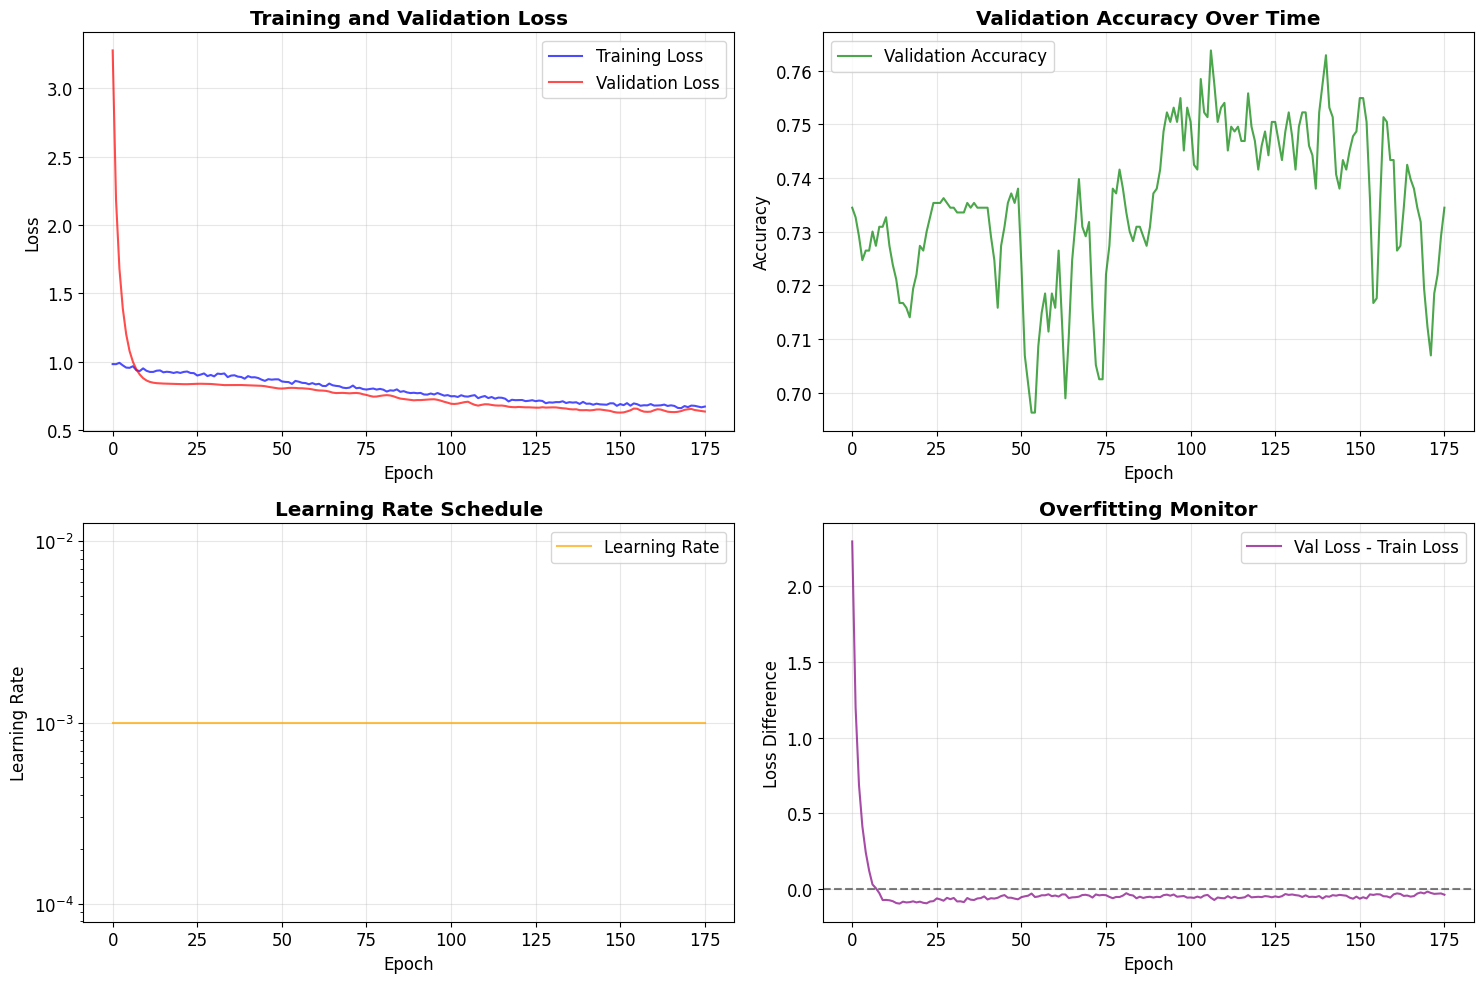


✅ Model training completed successfully!
🎯 Ready for comprehensive evaluation and business analysis!


In [12]:
# 6. TRAINING VISUALIZATION
print(f"\n5️⃣ Visualizing Training Progress...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
ax1.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
ax1.plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
ax1.set_title('Training and Validation Loss', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curve
ax2.plot(val_accuracies, label='Validation Accuracy', color='green', alpha=0.7)
ax2.set_title('Validation Accuracy Over Time', fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Learning rate
learning_rates = []
# Note: This is a simplified version - in practice you'd track LR during training
ax3.plot(range(len(train_losses)), [0.001] * len(train_losses),
         label='Learning Rate', color='orange', alpha=0.7)
ax3.set_title('Learning Rate Schedule', fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_yscale('log')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Loss difference (overfitting indicator)
loss_diff = np.array(val_losses) - np.array(train_losses)
ax4.plot(loss_diff, label='Val Loss - Train Loss', color='purple', alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax4.set_title('Overfitting Monitor', fontweight='bold')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss Difference')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Model training completed successfully!")
print(f"🎯 Ready for comprehensive evaluation and business analysis!")